In [ ]:
# CS234 Final Project
# Using OPENAI gym Atari Game: Frogger
# Research on LLM & traditional RL combination

In [ ]:
# install environment
!pip install gymnasium==1.0.0 ale-py --quiet




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 36.2 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
from collections import deque
import torch.nn.functional as F



In [ ]:
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(DQN_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),  # Output: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Output: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Output: (64, 7, 7)
            nn.ReLU()
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(64*7*7, 512),  # Flattened CNN features
            nn.ReLU(),
            nn.Linear(512, action_dim)  # Output Q-values for each action
        )

    def forward(self, x):
        x = self.conv_layers(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc_layers(x)
        return x

In [ ]:
import numpy as np
import random
import collections
import cv2
import torch

loaded_rewards = []
class SumTree:
    """Binary tree for efficient priority sampling"""
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # SumTree structure
        self.data = np.zeros(capacity, dtype=object)  # Stores experiences
        self.size = 0
        self.pointer = 0  # Current data pointer

    def add(self, priority, data):
        """Add a new experience with given priority"""
        index = self.pointer + self.capacity - 1  # Leaf node index
        self.data[self.pointer] = data  # Store experience
        self.update(index, priority)  # Update tree
        self.pointer = (self.pointer + 1) % self.capacity  # Circular buffer
        self.size = min(self.size + 1, self.capacity)

    def update(self, index, priority):
        """Update a node priority and propagate changes"""
        change = priority - self.tree[index]
        self.tree[index] = priority
        while index != 0:
            index = (index - 1) // 2
            self.tree[index] += change

    def get_leaf(self, value):
        """Get an experience sample based on priority"""
        index = 0
        while index < self.capacity - 1:  # Traverse down the tree
            left = 2 * index + 1
            right = left + 1
            if value <= self.tree[left]:
                index = left
            else:
                value -= self.tree[left]
                index = right
        leaf_index = index - (self.capacity - 1)
        return index, self.tree[index], self.data[leaf_index]

    def total_priority(self):
        return self.tree[0]  # Root node

class PrioritizedReplayBuffer:
    """Replay Buffer with Prioritized Experience Replay (PER)"""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.alpha = alpha  # Priority exponent (0 = uniform, 1 = full prioritization)
        self.beta = beta  # Importance sampling correction factor
        self.beta_increment = beta_increment
        self.epsilon = 1e-5  # Small value to prevent zero priority
        self.expert_buffer = []
        self.expert_rewards = [13.0, 19.0, 13.0, 12.0, 35.0, 22.0, 25.0, 12.0, 27.0, 32.0]

        # Load expert demonstrations
        for i in range(10):
            expert_data = np.load(f"./trajectories/trajectory_{i}.npy", allow_pickle=True)
            self.expert_buffer.append(expert_data)
        # Process expert demonstrations
        for example in self.expert_buffer:
            for pair in example:
                states = [cv2.resize(state, (84, 84)) for state in pair[0]]
                next_states = [cv2.resize(state, (84, 84)) for state in pair[3]]
                pair[0] = np.array(states, dtype=np.uint8)
                pair[3] = np.array(next_states, dtype=np.uint8)
                priority = 5.0  # Expert samples should have high initial priority
                self.tree.add(priority, tuple(pair))
        self.sort_expert_buffer()
        print(f"Expert buffer size: {len(self.expert_buffer)}")

    def sort_expert_buffer(self):
        """Sort expert buffer by total rewards (ascending)"""
        sorted_pairs = sorted(zip(self.expert_rewards, self.expert_buffer), key=lambda x: x[0])
        self.expert_rewards, self.expert_buffer = zip(*sorted_pairs)  # Unzip sorted tuples
        self.expert_rewards = list(self.expert_rewards)
        self.expert_buffer = list(self.expert_buffer)

    def update_expert_buffer(self, new_trajectory):
        """Update expert buffer if the new trajectory has a higher score than the lowest one"""
        new_reward = sum(sample[2] for sample in new_trajectory)  # Compute total reward

        if new_reward > self.expert_rewards[0]:  # Compare with lowest reward
            print(f"New trajectory with reward {new_reward} replaces lowest reward {self.expert_rewards[0]}")

            # Replace the lowest reward trajectory
            self.expert_buffer[0] = new_trajectory
            self.expert_rewards[0] = new_reward

            # Re-sort buffer to maintain ordering
            self.sort_expert_buffer()

    def add(self, state, action, reward, next_state, done, error):
        """Add experience with priority based on TD error"""
        priority = (np.abs(error) + self.epsilon) ** self.alpha
        experience = (
            np.array(state, dtype=np.uint8),
            action,
            int(reward),
            np.array(next_state, dtype=np.uint8),
            bool(done)
        )
        self.tree.add(priority, experience)

    def sample(self, batch_size):
        """Sample from both self-experience and expert buffer"""
        batch = []
        indexes = []
        segment = self.tree.total_priority() / (batch_size//2)  # Divide buffer into equal segments

        # Sample from PER replay buffer
        for i in range(batch_size // 2):
            value = random.uniform(i * segment, (i + 1) * segment)
            index, priority, experience = self.tree.get_leaf(value)
            batch.append(experience)
            indexes.append(index)

        # Sample from expert buffer (uniform sampling)
        expert_buffer = []
        for pair in self.expert_buffer:
            expert_buffer.extend(pair)
        expert_batch = random.sample(expert_buffer, batch_size // 2)

        batch.extend(expert_batch)
        random.shuffle(batch)

        state, action, reward, next_state, done = zip(*batch)

        self.beta = min(1.0, self.beta + self.beta_increment)  # Increase beta over time
        probabilities = np.array([self.tree.tree[i] for i in indexes]) / self.tree.total_priority()
        importance_weights = (self.capacity * probabilities) ** (-self.beta)
        if importance_weights.max() > 0:
            importance_weights /= importance_weights.max()  # Normalize

        return (
            torch.FloatTensor(np.array(state)) / 255.0,  # Normalize pixel values
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(np.array(next_state)) / 255.0,
            torch.FloatTensor(done),
            indexes,
            torch.FloatTensor(importance_weights)
        )

    def update_priorities(self, indexes, errors):
        """Update priorities after training"""
        for index, error in zip(indexes, errors):
            priority = (np.abs(error) + self.epsilon) ** self.alpha
            self.tree.update(index, priority)

    def size(self):
        return self.tree.size


# class ReplayBuffer:
#     def __init__(self, capacity):
#         self.buffer = collections.deque(maxlen=capacity)
#         self.expert_buffer = []
#         # load expert's demo
#         for i in range(10):
#             expert_buffer = np.load(f"./trajectories/trajectory_{i}.npy", allow_pickle=True)
#             self.expert_buffer.extend(expert_buffer)
#         for pair in self.expert_buffer:
#             states = pair[0]
#             next_states = pair[3]
#             resize_states = []
#             resize_next_states = []
#             for state in states:
#                 resize_states.append(cv2.resize(state, (84, 84)))
#             for state in next_states:
#                 resize_next_states.append(cv2.resize(state, (84, 84)))
#             pair[0] = resize_states
#             pair[3] = resize_next_states
#             pair = (
#                 np.array(pair[0], dtype=np.uint8),
#                 pair[1],
#                 int(pair[2]),
#                 np.array(pair[3], dtype=np.uint8),
#                 bool(pair[4])
#             )
#         print(f"Expert buffer size: {len(self.expert_buffer)}")

#     def push(self, state, action, reward, next_state, done):
#         self.buffer.append((
#             np.array(state, dtype=np.uint8),
#             action,
#             int(reward),
#             np.array(next_state, dtype=np.uint8),
#             bool(done)
#         ))


#         # self.buffer.append((state, action, reward, next_state, done))

#     def sample(self, batch_size):
#         totalbuffer = self.buffer + self.expert_buffer
#         batch1 = random.sample(self.buffer, batch_size//2)
#         batch2 = random.sample(self.expert_buffer, batch_size//2)
#         batch = batch1 + batch2
#         random.shuffle(batch)
#         state, action, reward, next_state, done = zip(*batch)

#         return (
#             torch.FloatTensor(np.array(state)) / 255.0,  # Normalize pixels
#             torch.LongTensor(action),
#             torch.FloatTensor(reward),
#             torch.FloatTensor(np.array(next_state)) / 255.0,
#             torch.FloatTensor(done)
#         )

#     def size(self):
#         return len(self.buffer)

In [ ]:
# test replay buffer
replay_buffer = PrioritizedReplayBuffer(1000)

Expert buffer size: 10


In [ ]:
def select_action(env, model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action (exploration)

    state = torch.FloatTensor(state).unsqueeze(0) / 255.0  # Normalize pixels
    state = state.to(device)
    with torch.no_grad():
        return model(state).argmax().item()
def train(model, target_model, buffer, optimizer, batch_size, gamma):
    if buffer.size() < batch_size:
        return

    # Sample batch from experience replay
    states, actions, rewards, next_states, dones, indexes, importance_weights = buffer.sample(batch_size)

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    # Compute Q-values for current states
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-values of taken actions

    # Compute next Q-values from the target network
    next_q_values = target_model(next_states).max(1)[0].detach()  # Max Q-value of next state

    dones = dones.to(torch.bool)
    # Zero next_q_values for terminal states
    next_q_values[dones] = 0.0

    # Compute target Q-values
    target_q_values = rewards + gamma * next_q_values

    # Compute TD-error
    td_errors = torch.abs(q_values - target_q_values).detach().cpu().numpy()

    # Compute loss using Huber loss (smooth_l1_loss)
    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()

    # Update priorities in the replay buffer
    buffer.update_priorities(indexes, td_errors)

# def train(model, target_model, buffer, optimizer, batch_size, gamma):
#     if buffer.size() < batch_size:
#         return

#     states, actions, rewards, next_states, dones = buffer.sample(batch_size)

#     states = states.to(device)
#     actions = actions.to(device)
#     rewards = rewards.to(device)
#     next_states = next_states.to(device)
#     dones = dones.to(device)

#     q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
#     next_q_values = target_model(next_states).max(1)[0]
#     target_q_values = rewards + gamma * next_q_values * (1 - dones)

#     loss = nn.MSELoss()(q_values, target_q_values.detach())

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()



Streaming output truncated to the last 5000 lines.
Episode 5004, Reward: 9.0, Epsilon: 0.100
Episode 5005, Reward: 19.0, Epsilon: 0.100
Episode 5006, Reward: 18.0, Epsilon: 0.100
Episode 5007, Reward: 12.0, Epsilon: 0.100
Episode 5008, Reward: 15.0, Epsilon: 0.100
Episode 5009, Reward: 15.0, Epsilon: 0.100
Episode 5010, Reward: 11.0, Epsilon: 0.100
Episode 5011, Reward: 18.0, Epsilon: 0.100
Episode 5012, Reward: 23.0, Epsilon: 0.100
Episode 5013, Reward: 9.0, Epsilon: 0.100
Episode 5014, Reward: 12.0, Epsilon: 0.100
Episode 5015, Reward: 12.0, Epsilon: 0.100
Episode 5016, Reward: 15.0, Epsilon: 0.100
Episode 5017, Reward: 18.0, Epsilon: 0.100
Episode 5018, Reward: 21.0, Epsilon: 0.100
Episode 5019, Reward: 15.0, Epsilon: 0.100
Episode 5020, Reward: 19.0, Epsilon: 0.100
Episode 5021, Reward: 16.0, Epsilon: 0.100
Episode 5022, Reward: 19.0, Epsilon: 0.100
Episode 5023, Reward: 14.0, Epsilon: 0.100
Episode 5024, Reward: 20.0, Epsilon: 0.100
Episode 5025, Reward: 15.0, Epsilon: 0.100
Episo

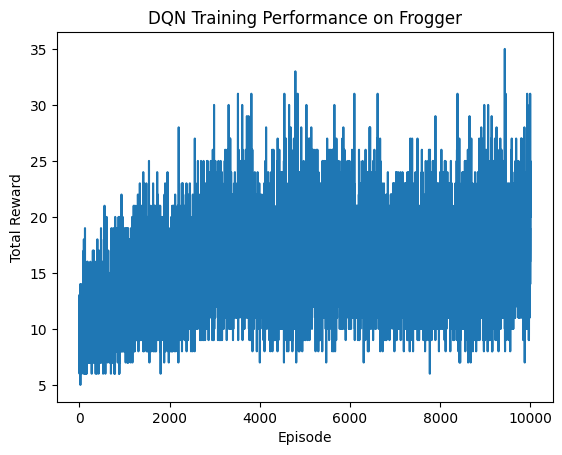

In [ ]:
# Create the Atari environment


env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")  # Create Atari env


env = GrayscaleObservation(env, keep_dim=False)
env = ResizeObservation(env, (84, 84))

frame_stack = deque(maxlen=4)

# Check Action / State space
obs, info = env.reset()
for _ in range(4):
    frame_stack.append(obs)

def stack_frames(frame_stack, new_frame):
    frame_stack.append(new_frame)  # Add new frame to the stack
    stacked_obs = np.stack(frame_stack, axis=0)  # Convert deque to NumPy array
    return stacked_obs


action_dim = env.action_space.n
print(f"Observation space: {env.observation_space}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn = DQN_CNN(4, action_dim).to(device)
target_dqn = DQN_CNN(4, action_dim).to(device)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
replay_buffer = PrioritizedReplayBuffer(capacity=8000)

num_episodes = 10000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.9995
target_update_freq = 100
td_error = 0.5
rewards_list = []

for episode in range(num_episodes):
    state, info = env.reset()
    # skip first 100 frames as no_op_frames
    for i in range(100):
      next_state, reward, done, info, _ = env.step(0)
      stack_frames(frame_stack, next_state)

    state = np.array(next_state).squeeze()
    total_reward = 0
    done = False
    trajectory = []
    while not done:
        stacked_state = stack_frames(frame_stack, state)
        action = select_action(env, dqn, stacked_state, epsilon)
        next_state, reward, done, info, _ = env.step(action)
        next_state = np.array(next_state).squeeze()
        next_stacked_state = stack_frames(frame_stack, next_state)

        replay_buffer.add(stacked_state, action, reward, next_stacked_state, done, td_error)
        state = next_state
        stacked_state = next_stacked_state
        total_reward += reward

        train(dqn, target_dqn, replay_buffer, optimizer, batch_size, gamma)
        trajectory.append((stacked_state, action, reward, next_stacked_state, done))

    loaded_rewards.append(total_reward)
    replay_buffer.update_expert_buffer(trajectory)
    rewards_list.append(total_reward)
    # store the model
    if episode % 500 == 0:
        torch.save(dqn.state_dict(), f"models/frogger_dqn_model_{episode}.pth")
    if episode % target_update_freq == 0:
        target_dqn.load_state_dict(dqn.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

plt.plot(rewards_list)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance on Frogger")
plt.show()

# store the model
torch.save(dqn.state_dict(), "frogger_dqn_model.pth")
# save the rewards_list in a txt file with comma separated
np.savetxt("frogger_dqn_rewards.txt", rewards_list, delimiter=",")

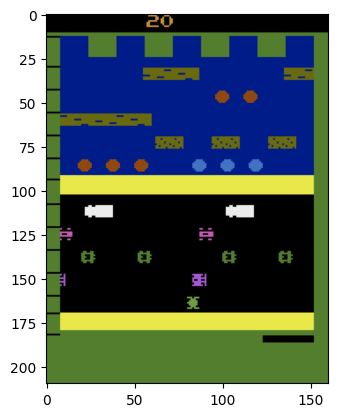

Total Steps: 290


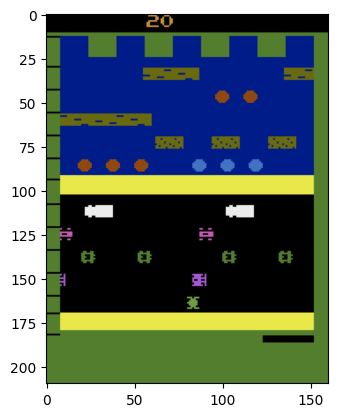

In [ ]:
# draw dqn playing game
state, info = env.reset()
state = np.array(state).squeeze()
done = False
step = 0
while not done:
    step += 1
    stacked_state = stack_frames(frame_stack, state)
    action = select_action(env, dqn, stacked_state, epsilon)
    next_state, reward, done, info, _ = env.step(action)
    next_state = np.array(next_state).squeeze()
    next_stacked_state = stack_frames(frame_stack, next_state)

    state = next_state
    stacked_state = next_stacked_state

    if done:
        break

    img = env.render()
    # store frame as pngs
    plt.imsave(f"./video1/frame_{step}.png", img)
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())
print(f"Total Steps: {step}")
env.close()

In [ ]:
import gymnasium as gym
import numpy as np

# Create Frogger environment
env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")

# Reset the environment
obs, info = env.reset()

# Check how many frames the agent cannot move
no_op_frames = 0
action = 2  # Move Up (example)

for i in range(200):  # Check the first 100 frames
    next_obs, reward, done, truncated, info = env.step(action)

    if reward != 0:  # If reward changes, movement is possible
        break

    no_op_frames += 1

print(f"Frogger cannot move for ~{no_op_frames} frames after reset.")



Frogger cannot move for ~200 frames after reset.


In [ ]:
# Training Model
# Train the model (adjust steps based on computing power)
model.learn(total_timesteps=50000)  # Train for 500k timesteps
model.save("pong_dqn_stablebaseline")

Logging to ./dqn_atari_tensorboard/DQN_5


In [ ]:
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward}, Std Dev: {std_reward}")

NameError: name 'evaluate_policy' is not defined

KeyboardInterrupt: 

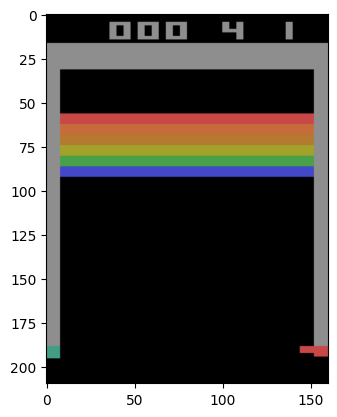

In [ ]:
obs, _ = env.reset()
for i in range(500):  # Play for 500 timesteps
    action, _ = model.predict(obs)  # Get action from model
    obs, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        obs, _ = env.reset()

    # Render & visualize
    img = env.render()
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())

env.close()

In [ ]:
import os
os.system("ffmpeg -i video1/frame_%01d.png -vcodec mpeg4 -y movie.mp4")


0

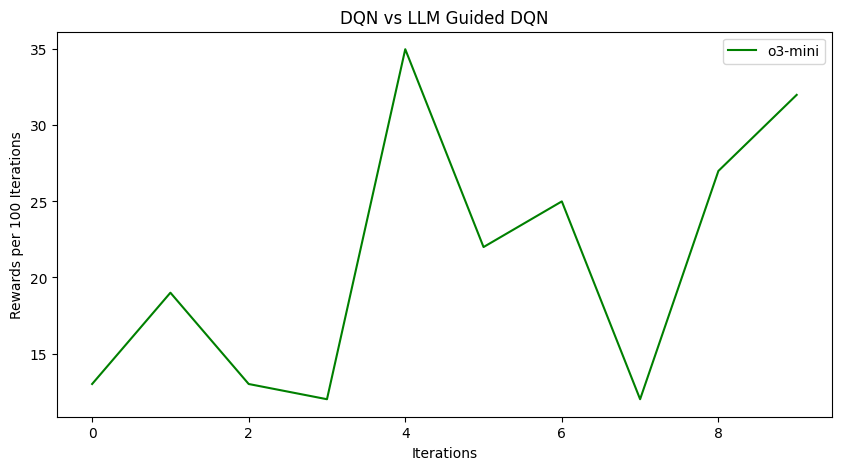

In [ ]:
# draw plot
timesteps = np.arange(10)
plt.figure(figsize=(10, 5))
plt.plot(timesteps, loaded_rewards, label="o3-mini", color='green')
plt.xlabel("Test Run")
plt.ylabel("Rewards")
plt.title("LLM played results")
plt.legend()
plt.show()



In [ ]:
print(loaded_rewards)

[13.0, 19.0, 13.0, 12.0, 35.0, 22.0, 25.0, 12.0, 27.0, 32.0]


In [ ]:
for i in range(5001):
    if i%500 == 0:
        # load dqn model from models folder
        dqn = DQN_CNN(4, action_dim).to(device)
        dqn.load_state_dict(torch.load(f"models/frogger_dqn_model_{i}.pth"))
        dqn.eval()
        total_reward = 0.0
        for j in range(100):
            state, info = env.reset()
            running = True
            while running:
                stacked_state = stack_frames(frame_stack, state)
                state, reward, done, info, _ = env.step(select_action(env, dqn, stacked_state, 0))
                total_reward += reward
                if done:

                    running = False
        print(f"Model {i}, Ave Reward: {total_reward/100}")



<ipython-input-44-ee68ee08842d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn.load_state_dict(torch.load(f"models/frogger_dqn_model_{i}.pth"))


Model 0, Ave Reward: 1.0
Model 500, Ave Reward: 15.17
Model 1000, Ave Reward: 20.02
Model 1500, Ave Reward: 20.4
Model 2000, Ave Reward: 20.81
Model 2500, Ave Reward: 19.82
Model 3000, Ave Reward: 23.76
Model 3500, Ave Reward: 14.69
Model 4000, Ave Reward: 18.83
Model 4500, Ave Reward: 17.32
Model 5000, Ave Reward: 23.35


In [ ]:
for i in range(5001):
    if i%500 == 0:
        # load dqn model from models folder
        dqn = DQN_CNN(4, action_dim).to(device)
        dqn.load_state_dict(torch.load(f"models2/frogger_dqn_model_{i}.pth"))
        dqn.eval()
        total_reward = 0.0
        running_times = 100
        if i < 500:
          running_times = 1
        for j in range(running_times):
            state, info = env.reset()
            running = True
            while running:
                stacked_state = stack_frames(frame_stack, state)
                state, reward, done, info, _ = env.step(select_action(env, dqn, stacked_state, 0))
                total_reward += reward
                if done:

                    running = False
        print(f"Model {i}, Ave Reward: {total_reward/100}")

<ipython-input-45-6c6ca5682544>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn.load_state_dict(torch.load(f"models2/frogger_dqn_model_{i}.pth"))


Model 0, Ave Reward: 0.05
Model 500, Ave Reward: 16.29
Model 1000, Ave Reward: 12.52
Model 1500, Ave Reward: 15.72
Model 2000, Ave Reward: 15.57
Model 2500, Ave Reward: 13.22
Model 3000, Ave Reward: 13.99
Model 3500, Ave Reward: 17.64
Model 4000, Ave Reward: 12.23
Model 4500, Ave Reward: 12.4
Model 5000, Ave Reward: 15.78
